# Results

using the gridded product

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

### Gridded Dataset

In [3]:
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES

ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds = ds[['TG_EAST_C', 'TG_WEST_C', 'SG_EAST', 'SG_WEST']]

ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True)

### ORAS5 dataset

In [4]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)
oras5=oras5.rename({'depth':'DEPTH','time':'TIME'})

oras5_EB= oras5.sel(latitude = 57.1, longitude = -9.6 -0.5, method = 'nearest')
oras5_WB = oras5.sel(latitude = 57.5, longitude = -12.5 +0.5, method = 'nearest')

### Oxygen data

In [5]:
file_name = "data/rteb_all_1D.nc"
ds_eb = xr.open_dataset(file_name)
ds_eb = ds_eb.rename({'depth':'DEPTH','time':'TIME'})
ds_oxy = ds_eb.oxy

In [6]:
ds_oxy = xr.merge([ds1D, ds_oxy])

In [7]:
ds_oxy = ds_oxy.rename({'oxy':'OXY_EAST'})

### Depths

In [8]:
depth_EB = [50, 75, 100, 250, 500, 750, 950, 1000, 1250, 1500, 1600, 1750]
depth_WB = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]

# Functions

In [9]:
def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)     
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)     
    return mhws, mcss, clim, clim_cold, t, temp  

In [10]:
def DICT_func(data, depth):  
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}
   
    for n in depth:
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [11]:
def OV_stacked_ax_events(dict, n, num):

    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]   
        ax[num].axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink')

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        ax[num].axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan')

    ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
    ax[num].grid(axis = 'x')
    ax[num].set_ylabel(str(n),rotation=0, labelpad=15)

       
    ax[num].tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False);
    

In [12]:
def Vars_and_events(dict, ds, n, invert=False, seventeen=False):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    fig, ax = plt.subplots(figsize=(20,3),frameon=False)
    plt.subplot(1,1,1)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', alpha=0.7)
        
    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', alpha=0.7)
    
    # plot oxygen concentration
    
    if seventeen:
        plt.xlim(date(2017,5,10), date(2018,7,10))
    else:
        plt.xlim(date(2014,7,15), date(2020,10,20))
    plt.plot(dates, ds.sel(DEPTH = n, method = 'nearest'), 'k')
    
    
    plt.grid()
    #plt.legend()
    plt.ylabel(str(n))
    
    if invert:
        plt.gca().invert_yaxis()


# Create Dictionaries

### Gridded Data

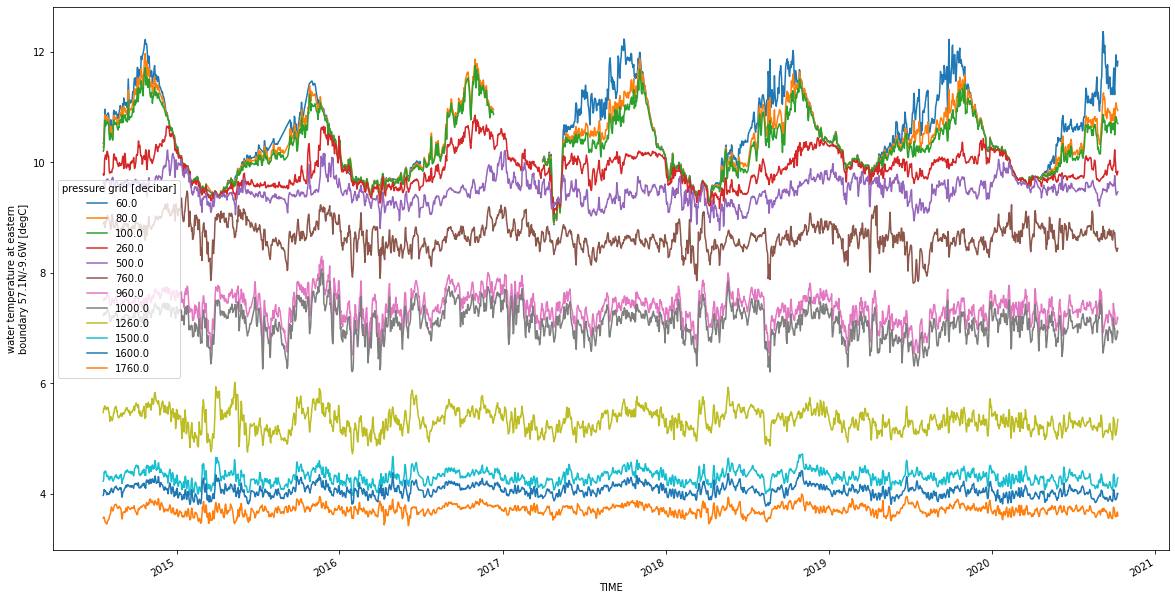

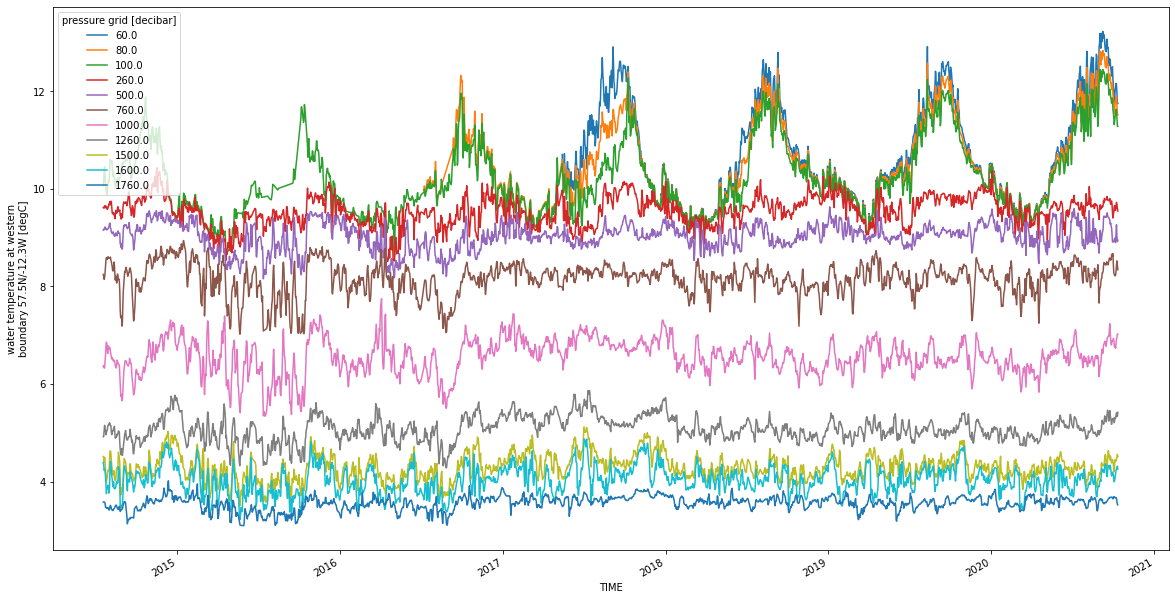

In [13]:
# create a mask file...
iper_60 = [np.datetime64('2016-07-01'),np.datetime64('2017-03-30')]
iper_80 = [np.datetime64('2016-12-12'),np.datetime64('2017-03-30')]
iper_100 = [np.datetime64('2016-12-12'),np.datetime64('2017-03-30')]
iper_clim = [np.datetime64('2016-06-01'),np.datetime64('2017-05-31')]
ds_eb = ds1D.sel(DEPTH=depth_EB,method='nearest').drop_vars(('TG_WEST_C','SG_WEST'))
mask_eb = (ds_eb.TG_EAST_C==ds_eb.TG_EAST_C)
mask_eb = mask_eb.sel(DEPTH=depth_EB[3:],method='nearest')
mask_60 = (((ds_eb.sel(DEPTH=60).TIME<iper_60[0]) | (ds_eb.sel(DEPTH=60).TIME>iper_60[1])))
mask_80 = (((ds_eb.sel(DEPTH=80).TIME<iper_80[0]) | (ds_eb.sel(DEPTH=80).TIME>iper_80[1])))
mask_100 = (((ds_eb.sel(DEPTH=100).TIME<iper_100[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_100[1])))
mask_clim = (((ds_eb.sel(DEPTH=100).TIME<iper_clim[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_clim[1])))
mask_clim = xr.concat([mask_clim,mask_clim,mask_clim,mask_eb],dim='DEPTH')
mask_eb = xr.concat([mask_60,mask_80,mask_100,mask_eb],dim='DEPTH')
mask_clim.coords['DEPTH'] = mask_eb.DEPTH

ds1D.TG_EAST_C.where(mask_eb).plot.line(x='TIME',figsize=(20,10))
ds1D.sel(DEPTH=depth_WB,method='nearest').TG_WEST_C.plot.line(x='TIME',figsize=(20,10))

In [14]:
ds1D['TG_EAST_C'] = ds1D.TG_EAST_C.where(mask_eb)
ds1D['SG_EAST'] = ds1D.SG_EAST.where(mask_eb)

In [15]:
EB = DICT_func(ds1D.TG_EAST_C, depth_EB)
WB = DICT_func(ds1D.TG_WEST_C, depth_WB)

In [16]:
# fix 100m 2017 data
temp_100_orig = EB['temp']['100']
clim_100_orig = EB['clim']['100']
dsNC = xr.concat([ds1D.sel(TIME = slice('2014-6-1', '2016-5-31')), ds1D.sel(TIME = slice('2017-6-1', '2020-5-31'))],dim='TIME')

# alternative timeline
t_alt = np.concatenate((np.arange(
        date(2014,6,1).toordinal(),
        date(2016,5,31).toordinal()+1,1), 
        np.arange(
        date(2017,6,1).toordinal(),
        date(2020,5,31).toordinal()+1,1)))

# alternative temperature
temp_alt = dsNC.TG_EAST_C.sel(DEPTH=100).squeeze().values 
temp_100 = ds1D.TG_EAST_C.sel(DEPTH=100)
temp_100 = temp_100.where((temp_100.TIME<np.datetime64('2016-12-10')) | (temp_100.TIME>np.datetime64('2017-05-17'))).squeeze().values

EB['temp']['100'] = temp_100
t_100 = EB['t']['100']

mhws_alt, clim_alt = mhw.detect(t_100, temp_100, climatologyPeriod= [2014.0, 2020.0], alternateClimatology=[t_alt,temp_alt])
EB['mhws']['100'] = mhws_alt
EB['clim']['100'] = clim_alt

mcss_alt, clim_cold_alt = mhw.detect(t_100,temp_100, climatologyPeriod= [2014.0, 2020.0], alternateClimatology=[t_alt,temp_alt], coldSpells=True)
EB['mcss']['100'] = mcss_alt
EB['clim_cold']['100'] = clim_cold_alt

### ORAS5 data

In [17]:
# alt clim from ORAS5 -› take only last 10 years of data
mhws_EB_10,mcss_EB_10,clim_EB_10,clim_cold_EB_10,t_EB_10,temp_EB_10 = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_EB: 
    temp_oras = np.array(oras5_EB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_EAST_C, n, climP=[2010,2019], altClim=[t_oras,temp_oras])
    mhws_EB_10.update({str(n):mhws})
    mcss_EB_10.update({str(n):mcss})
    clim_EB_10.update({str(n):clim})
    clim_cold_EB_10.update({str(n):clim_cold})
    t_EB_10.update({str(n):t})
    temp_EB_10.update({str(n):temp})
    
oras5_EB_10 = {'mhws':mhws_EB_10,'mcss':mcss_EB_10,'clim':clim_EB_10,'clim_cold':clim_cold_EB_10,'t':t_EB_10,'temp':temp_EB_10}

In [18]:
# alt clim from ORAS5 -› all years
mhws_EB_all,mcss_EB_all,clim_EB_all,clim_cold_EB_all,t_EB_all,temp_EB_all = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_EB: 
    temp_oras = np.array(oras5_EB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_EAST_C, n, climP=[1993,2019], altClim=[t_oras,temp_oras])
    mhws_EB_all.update({str(n):mhws})
    mcss_EB_all.update({str(n):mcss})
    clim_EB_all.update({str(n):clim})
    clim_cold_EB_all.update({str(n):clim_cold})
    t_EB_all.update({str(n):t})
    temp_EB_all.update({str(n):temp})
    
oras5_EB_all = {'mhws':mhws_EB_all,'mcss':mcss_EB_all,'clim':clim_EB_all,'clim_cold':clim_cold_EB_all,'t':t_EB_all,'temp':temp_EB_all}

In [19]:
# alt clim from ORAS5 -› take only last 10 years of data
mhws_WB_10,mcss_WB_10,clim_WB_10,clim_cold_WB_10,t_WB_10,temp_WB_10 = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_WB: 
    temp_oras = np.array(oras5_WB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_WEST_C, n, climP=[2010,2019], altClim=[t_oras,temp_oras])
    mhws_WB_10.update({str(n):mhws})
    mcss_WB_10.update({str(n):mcss})
    clim_WB_10.update({str(n):clim})
    clim_cold_WB_10.update({str(n):clim_cold})
    t_WB_10.update({str(n):t})
    temp_WB_10.update({str(n):temp})
    
oras5_WB_10 = {'mhws':mhws_WB_10,'mcss':mcss_WB_10,'clim':clim_WB_10,'clim_cold':clim_cold_WB_10,'t':t_WB_10,'temp':temp_WB_10}

In [20]:
# alt clim from ORAS5 -› all years
mhws_WB_all,mcss_WB_all,clim_WB_all,clim_cold_WB_all,t_WB_all,temp_WB_all = {},{},{},{},{},{}

t_oras = np.arange(
        date(1993,1,1).toordinal(),
        date(2019,12,31).toordinal()+1,1)

# Iterating through all instrument depths
for n in depth_WB: 
    temp_oras = np.array(oras5_WB.thetao_oras.sel(DEPTH=n, method= 'nearest'))
    
    mhws, mcss, clim, clim_cold, t, temp = MHW_func(ds1D.TG_WEST_C, n, climP=[1993,2019], altClim=[t_oras,temp_oras])
    mhws_WB_all.update({str(n):mhws})
    mcss_WB_all.update({str(n):mcss})
    clim_WB_all.update({str(n):clim})
    clim_cold_WB_all.update({str(n):clim_cold})
    t_WB_all.update({str(n):t})
    temp_WB_all.update({str(n):temp})
    
oras5_WB_all = {'mhws':mhws_WB_all,'mcss':mcss_WB_all,'clim':clim_WB_all,'clim_cold':clim_cold_WB_all,'t':t_WB_all,'temp':temp_WB_all}

# Plots

### MHW overview with all different clims

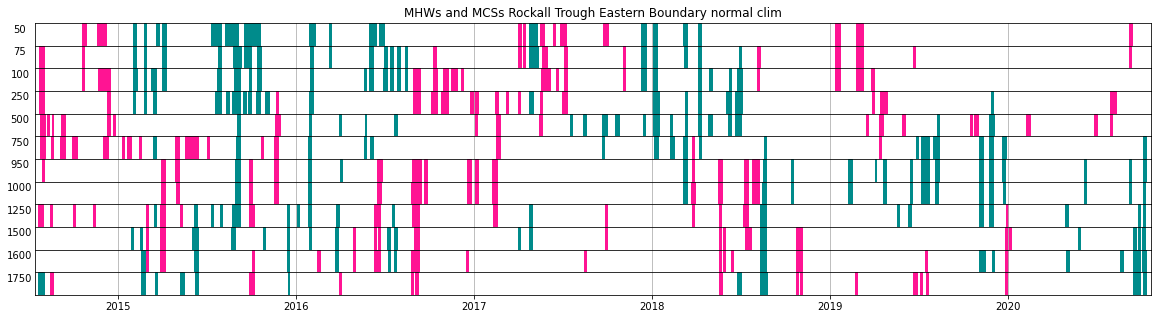

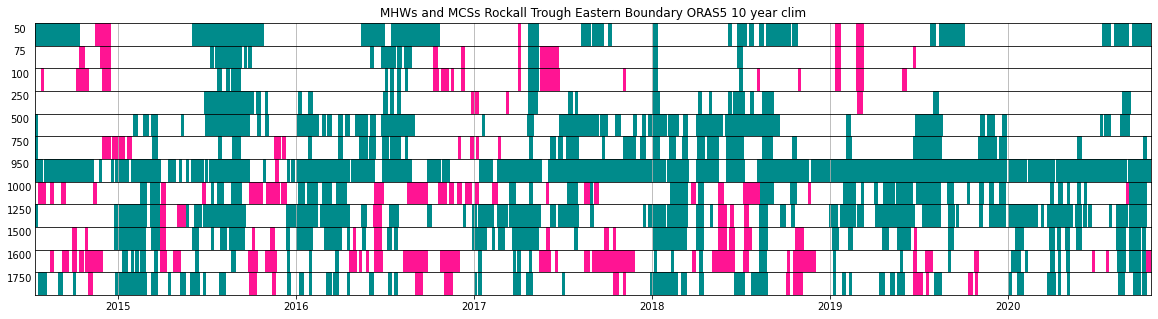

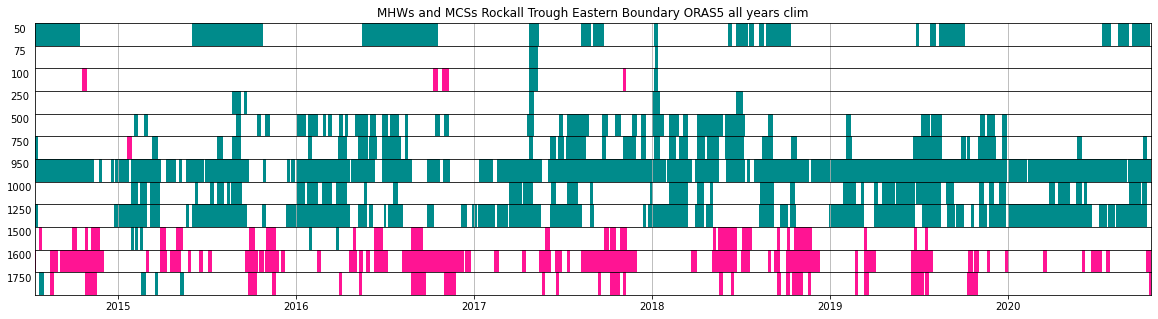

In [27]:
depth = depth_EB

title = 'MHWs and MCSs Rockall Trough Eastern Boundary normal clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(EB, n, i);
    if n == 50:
        ax[i].set_title(title)
#fig.savefig(f'figures/{title}', dpi = 300)

title = 'MHWs and MCSs Rockall Trough Eastern Boundary ORAS5 10 year clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(oras5_EB_10, n, i);
    if n == 50:
        ax[i].set_title(title)
#fig.savefig(f'figures/{title}', dpi = 300)

title = 'MHWs and MCSs Rockall Trough Eastern Boundary ORAS5 all years clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(oras5_EB_all, n, i);
    if n == 50:
        ax[i].set_title(title)

#fig.savefig(f'figures/{title}', dpi = 300)

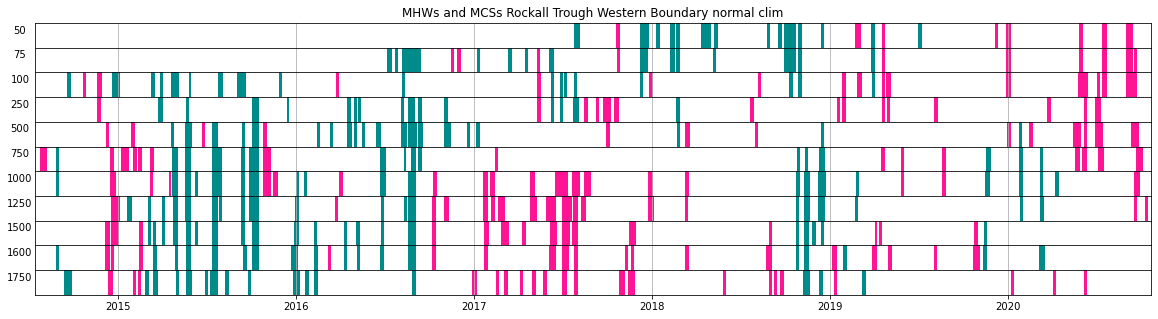

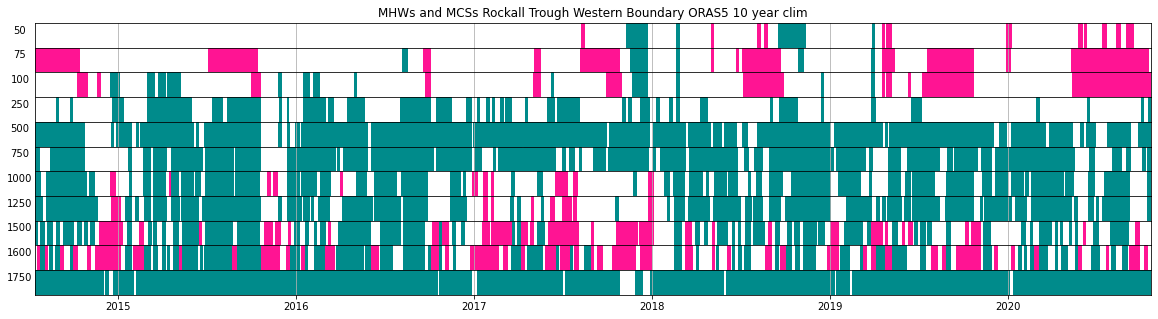

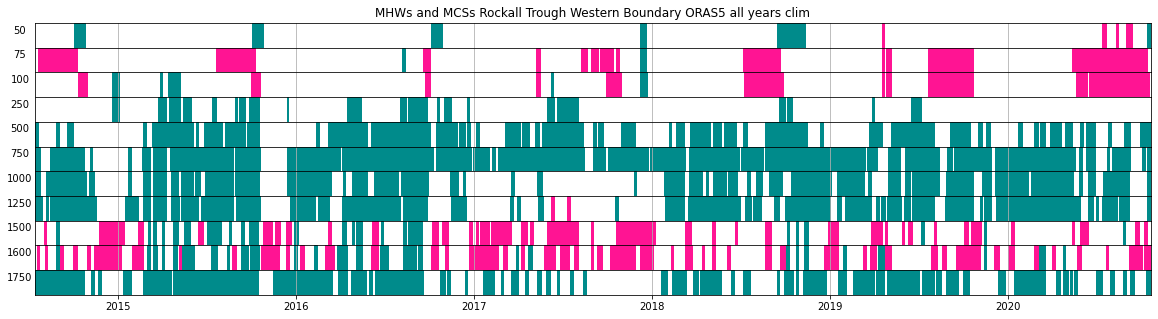

In [26]:
depth = depth_WB

title = 'MHWs and MCSs Rockall Trough Western Boundary normal clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(WB, n, i);
    if n == 50:
        ax[i].set_title(title)
#fig.savefig(f'figures/{title}', dpi = 300)

title = 'MHWs and MCSs Rockall Trough Western Boundary ORAS5 10 year clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(oras5_WB_10, n, i);
    if n == 50:
        ax[i].set_title(title)
#fig.savefig(f'figures/{title}', dpi = 300)

title = 'MHWs and MCSs Rockall Trough Western Boundary ORAS5 all years clim'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(oras5_WB_all, n, i);
    if n == 50:
        ax[i].set_title(title)
#fig.savefig(f'figures/{title}', dpi = 300)

### normal clim MHWs with Salinity

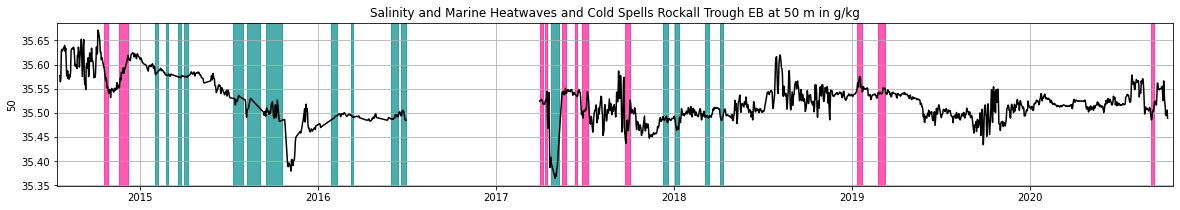

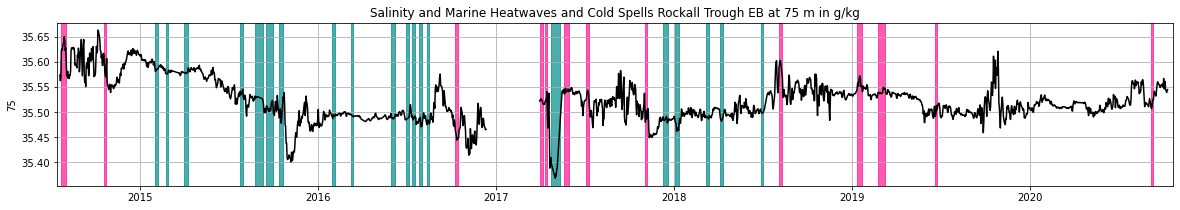

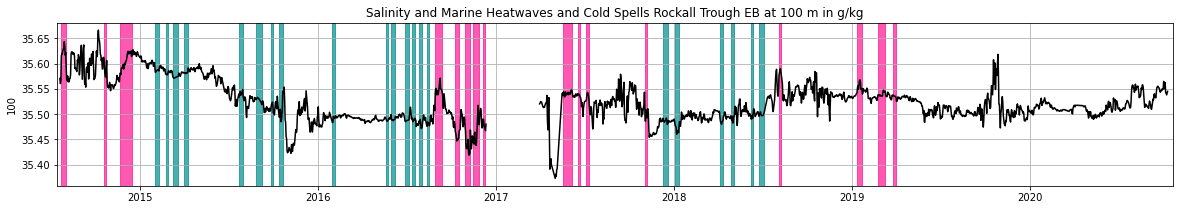

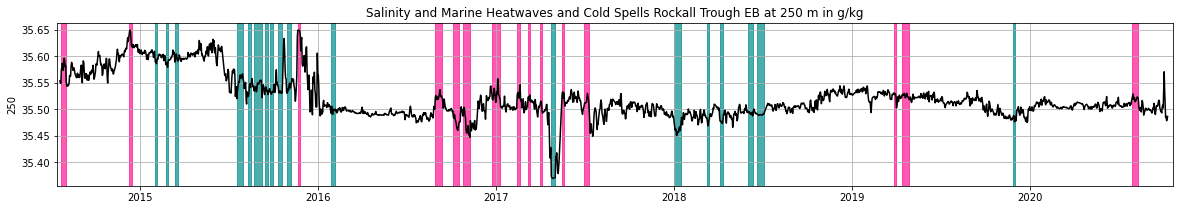

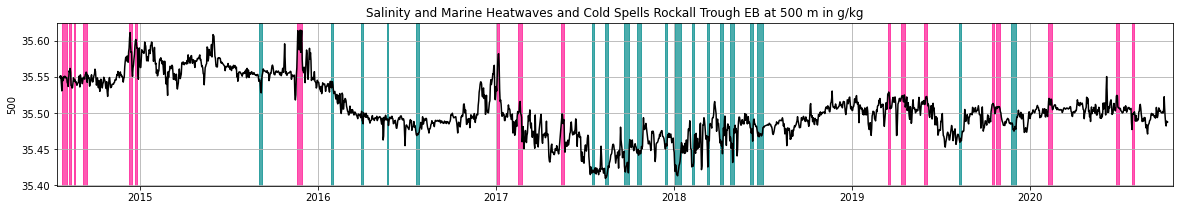

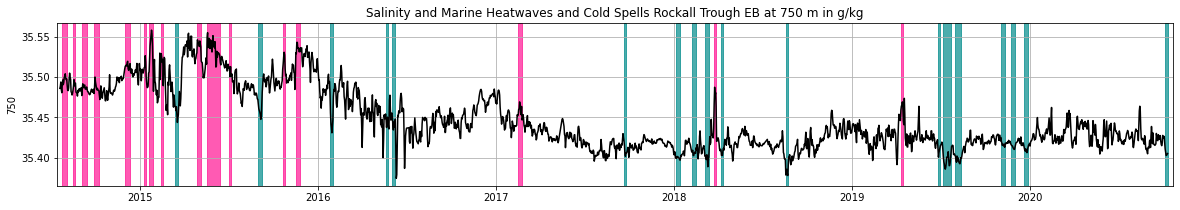

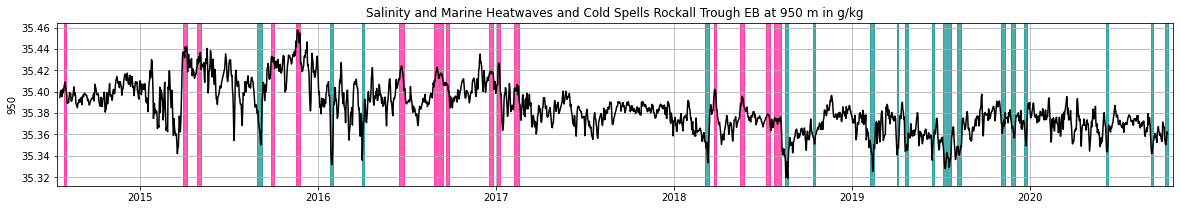

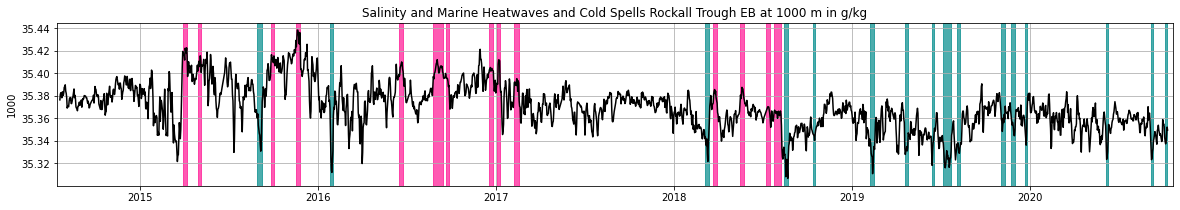

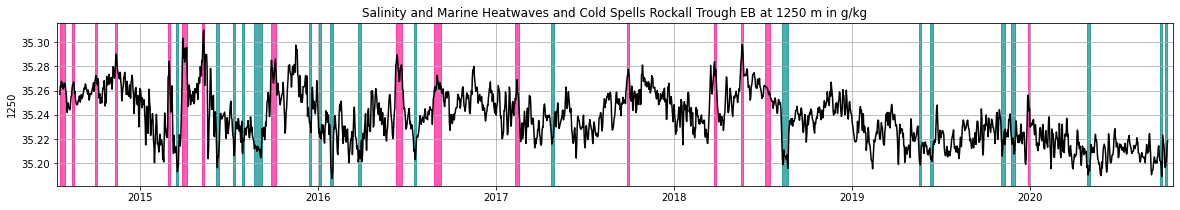

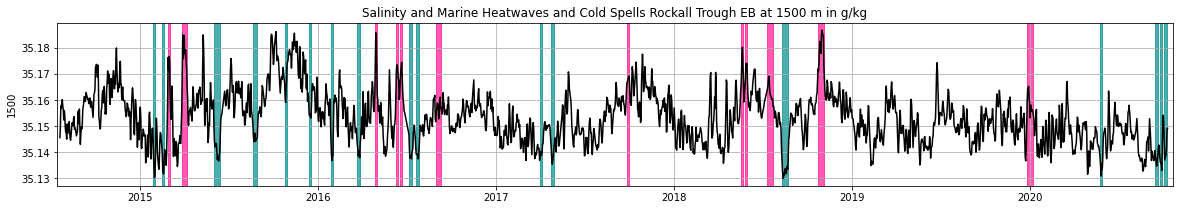

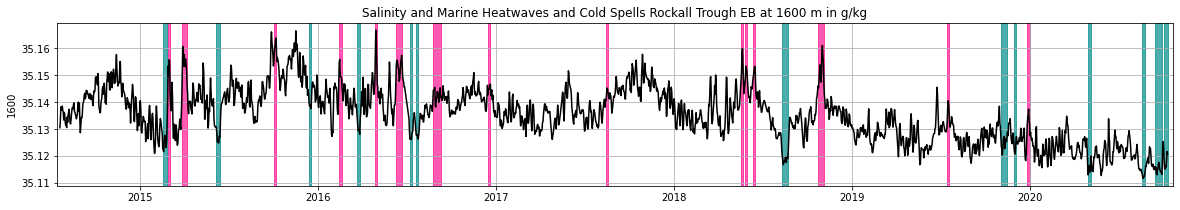

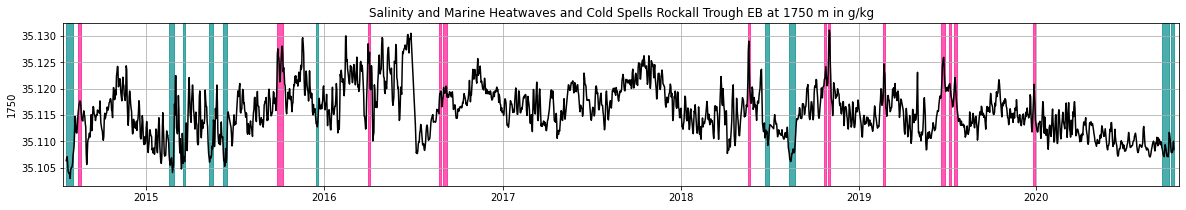

In [23]:
for n in depth_EB:
    Vars_and_events(EB, ds1D.SG_EAST, n)
    plt.title(f'Salinity and Marine Heatwaves and Cold Spells Rockall Trough EB at {n} m in g/kg')
    #plt.savefig(f'figures/Salinity_EB/Salinity_depth_{n}', dpi = 300)

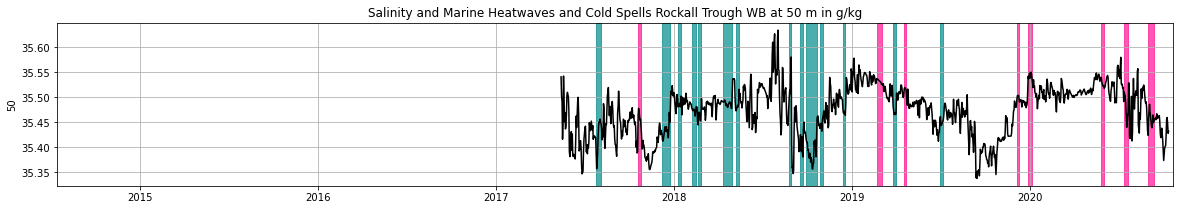

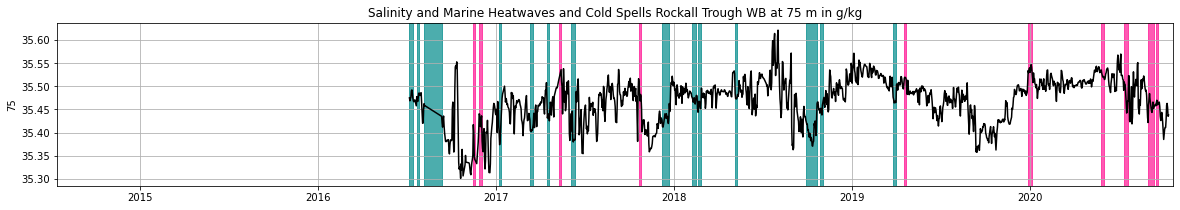

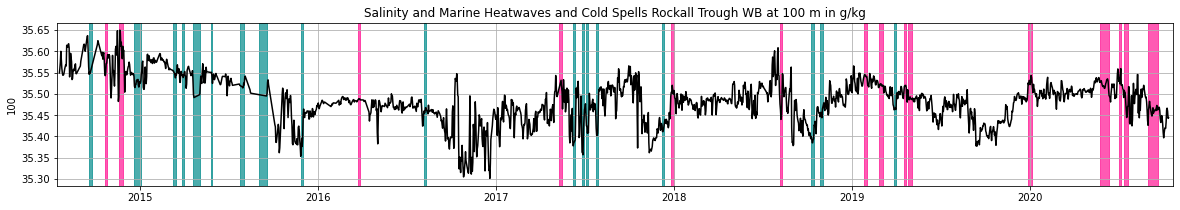

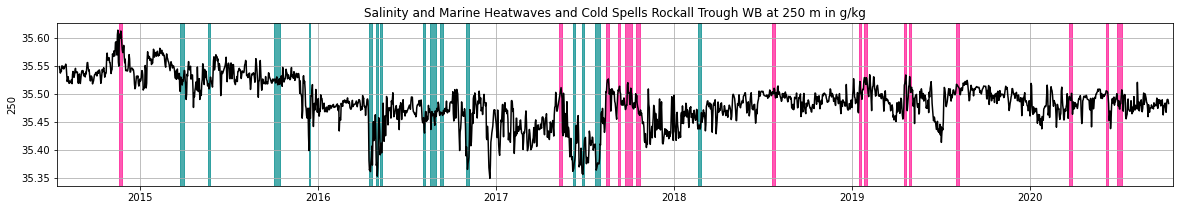

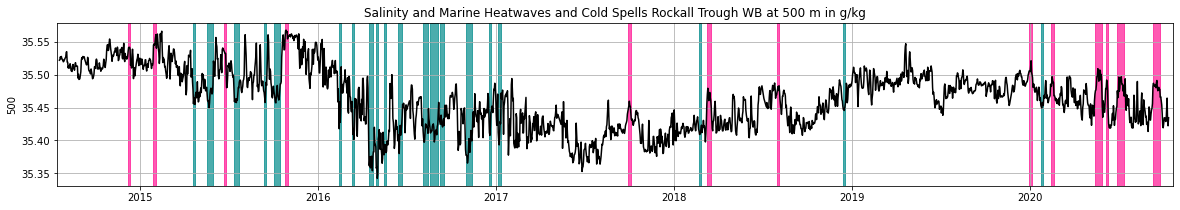

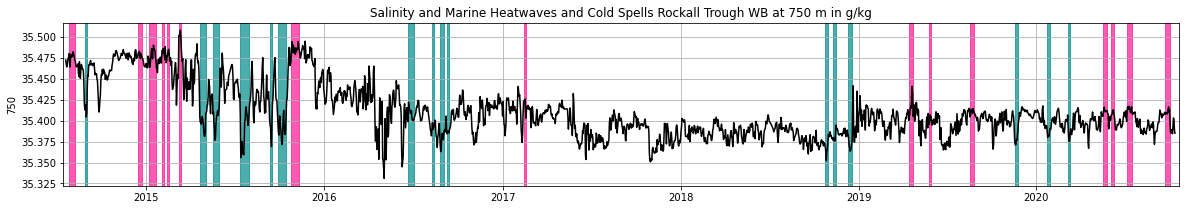

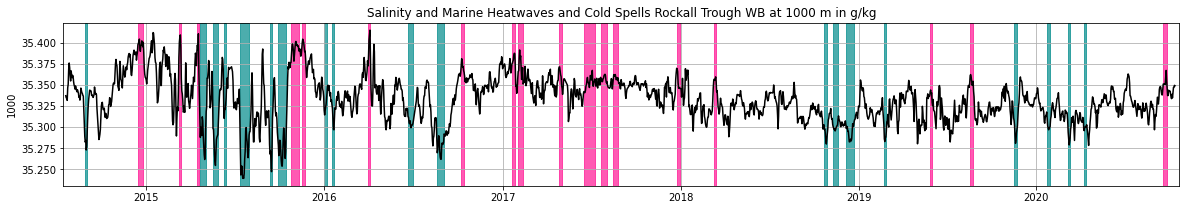

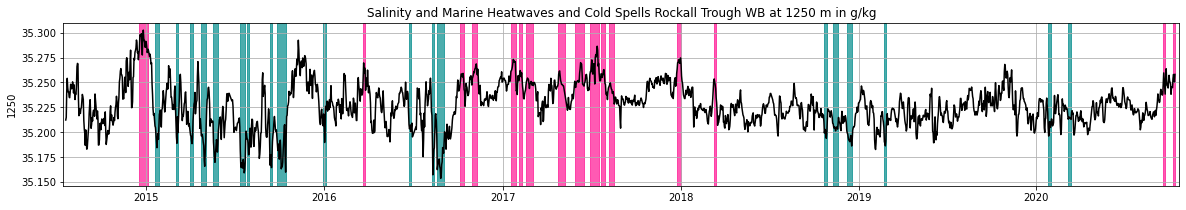

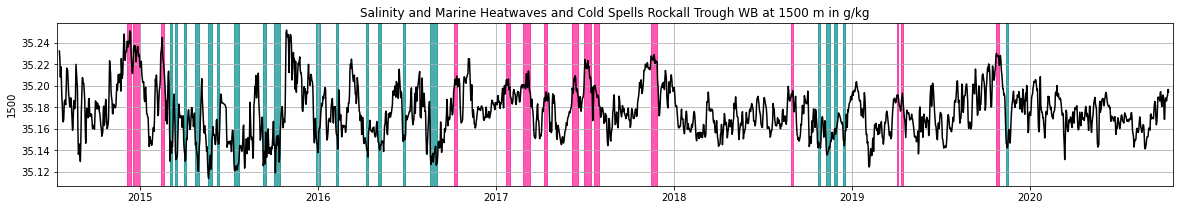

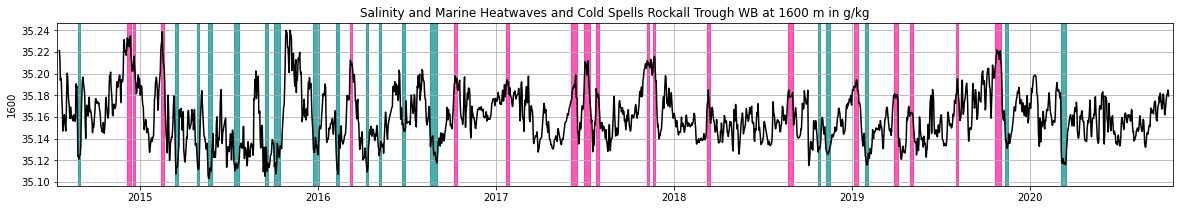

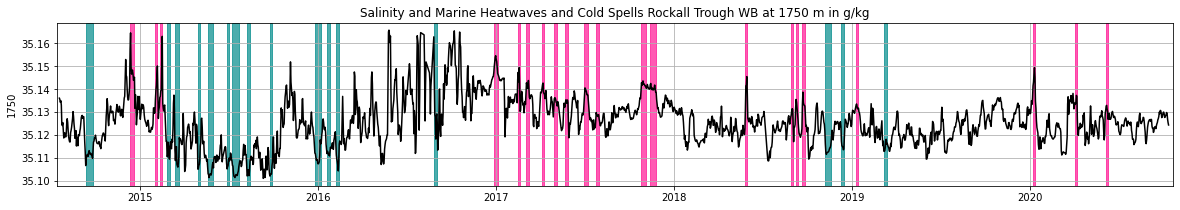

In [24]:
for n in depth_WB:
    Vars_and_events(WB, ds1D.SG_WEST, n)
    plt.title(f'Salinity and Marine Heatwaves and Cold Spells Rockall Trough WB at {n} m in g/kg')
    #plt.savefig(f'figures/Salinity_WB/Salinity_depth_{n}', dpi = 300)    

### normal clim MHWs with Oxygen

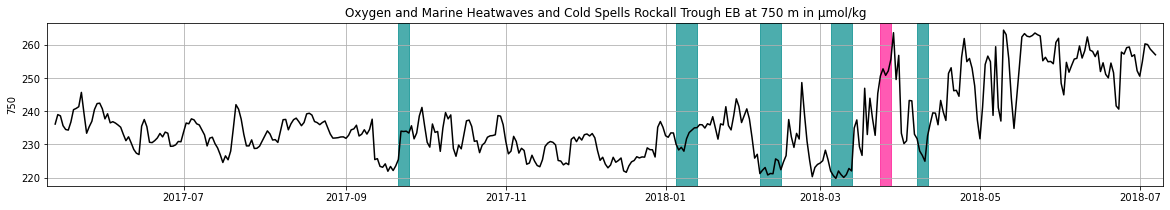

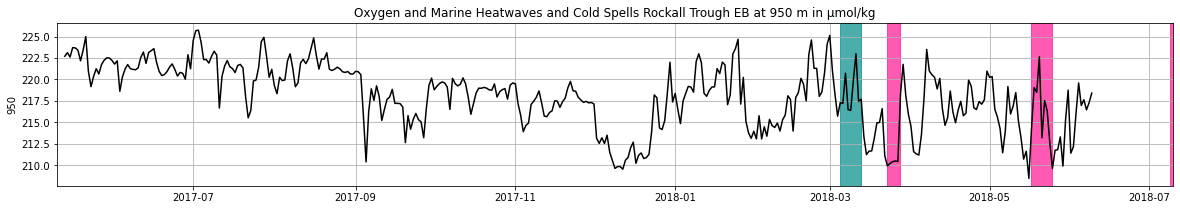

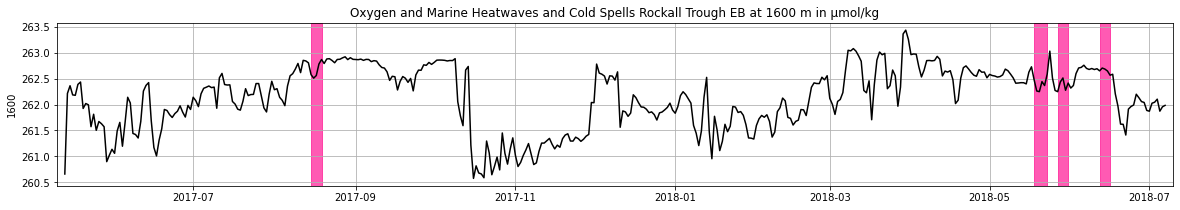

In [25]:
for n in [750, 950, 1600]:
    Vars_and_events(EB, ds_oxy.OXY_EAST, n, seventeen = True)
    plt.title(f'Oxygen and Marine Heatwaves and Cold Spells Rockall Trough EB at {n} m in µmol/kg') 
    #plt.savefig(f'figures/Oxygen_EB/Oxygen_depth_{n}', dpi = 300)        